## Notebook: Unsupervised learning


In this notebook, you will learn how to use unsupervised learning to discover  patterns in text.

We cover:
- Co-occurrence: the basic building block  
- LDA: classic topic modeling with word co-occurrence  
- BERTopic: transformer-based topic modeling with embeddings and clustering

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/merged_scopus.csv")

valid_types = ['Article', 'Book', 'Book chapter', 'Review']
df = df[df['Document Type'].isin(valid_types)]

df['text'] = df['Title'].fillna('') + '. ' + df['Abstract'].fillna('')

### Word co-occurrence

In [3]:

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=250)
X = vectorizer.fit_transform(df['text'])

# Raw co-occurrence matrix
co_matrix = (X.T @ X).toarray()
co_df = pd.DataFrame(co_matrix, index=vectorizer.get_feature_names_out(), columns=vectorizer.get_feature_names_out())
co_df


,19,2019,2020,2021,2022,2023,2024,2025,academic,access,...,use,used,user,users,using,value,various,work,world,years
19,12542,485,1739,1078,845,510,270,113,162,275,...,977,1366,297,801,2311,190,465,524,576,204
2019,485,920,210,126,148,117,77,21,65,61,...,255,288,72,155,473,90,97,103,82,133
2020,1739,210,1425,316,217,152,72,29,56,124,...,441,456,95,229,788,92,158,143,140,186
2021,1078,126,316,1186,176,129,74,29,83,92,...,396,438,108,208,690,119,189,152,140,167
2022,845,148,217,176,1245,179,139,64,78,95,...,448,460,103,209,786,102,154,131,109,166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
value,190,90,92,119,102,141,153,90,119,44,...,293,330,144,130,600,1780,162,135,61,70
various,465,97,158,189,154,200,239,134,132,116,...,457,440,192,200,897,162,1399,193,181,151
work,524,103,143,152,131,151,199,101,122,146,...,580,392,171,223,780,135,193,1852,140,98
world,576,82,140,140,109,104,105,83,51,72,...,262,274,160,134,484,61,181,140,857,80



### Normalization for word frequency.


In [4]:

import numpy as np

N = X.shape[0]
word1, word2 = 'policy', 'analysis'
i, j = vectorizer.vocabulary_.get(word1), vectorizer.vocabulary_.get(word2)

if i is not None and j is not None:
    p_xy = co_matrix[i, j] / N
    p_x = X[:, i].sum() / N
    p_y = X[:, j].sum() / N
    pmi = np.log2(p_xy / (p_x * p_y))
    print(f"Point-wise mutual information ({word1}, {word2}) = {pmi:.3f}")
else:
    print("Words not found.")


Point-wise mutual information (policy, analysis) = 0.045



### Co-occurrence graph

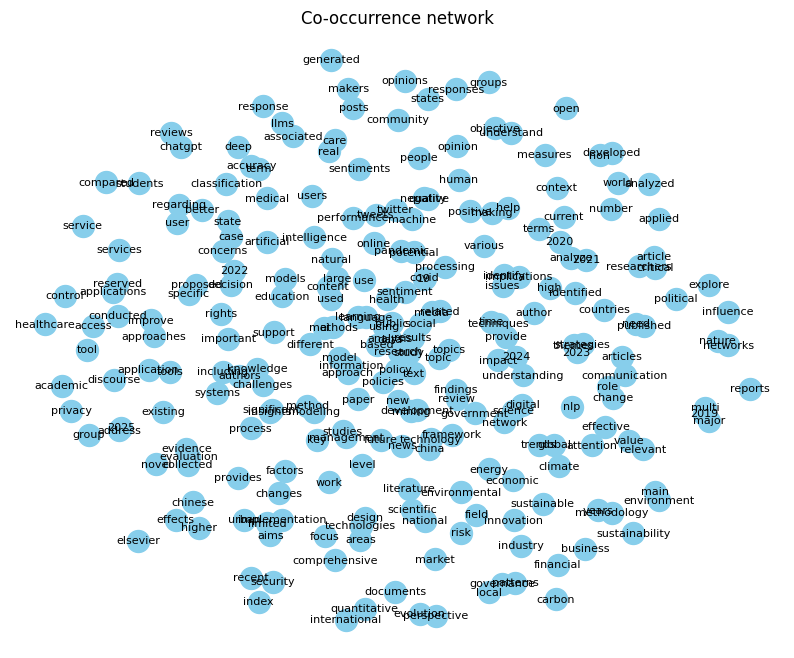

In [5]:
import networkx as nx

G = nx.Graph()
threshold = 50

for w1 in co_df.columns:
    for w2 in co_df.columns:
        if w1 != w2 and co_df.loc[w1, w2] > threshold:
            G.add_edge(w1, w2, weight=co_df.loc[w1, w2])

pos = nx.spring_layout(G, k=0.5)
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=250, node_color='skyblue')
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title("Co-occurrence network")
plt.axis('off')
plt.show()


## LDA topic modeling

In [6]:
from gensim import corpora, models
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS

texts = []
for doc in df['text']:
    tokens = doc.lower().split()
    tokens = [w for w in tokens if w not in STOPWORDS and len(w) > 2]
    texts.append(tokens)
    
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_model = models.LdaModel(corpus=corpus, num_topics=5, id2word=dictionary, passes=5)
lda_model.print_topics(num_topics=5, num_words=10)

[(0,
  '0.013*"data" + 0.007*"health" + 0.006*"language" + 0.006*"use" + 0.005*"research" + 0.005*"privacy" + 0.005*"medical" + 0.004*"information" + 0.004*"natural" + 0.004*"clinical"'),
 (1,
  '0.006*"research" + 0.005*"study" + 0.004*"education" + 0.003*"analysis" + 0.003*"language" + 0.003*"technological" + 0.003*"technology" + 0.003*"political" + 0.003*"educational" + 0.003*"patent"'),
 (2,
  '0.006*"model" + 0.006*"policy" + 0.006*"language" + 0.006*"learning" + 0.005*"data" + 0.005*"based" + 0.004*"information" + 0.004*"text" + 0.004*"proposed" + 0.004*"approach"'),
 (3,
  '0.015*"social" + 0.014*"public" + 0.013*"sentiment" + 0.012*"media" + 0.010*"analysis" + 0.007*"covid-19" + 0.007*"health" + 0.006*"study" + 0.006*"data" + 0.005*"twitter"'),
 (4,
  '0.019*"policy" + 0.010*"research" + 0.009*"analysis" + 0.007*"text" + 0.006*"study" + 0.005*"policies" + 0.004*"data" + 0.004*"mining" + 0.004*"development" + 0.004*"climate"')]

In [7]:
coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
print(f"Coherence: {coherence_model.get_coherence():.3f}")

# Gensim log perplexity
perplexity = lda_model.log_perplexity(corpus)
print(f"Log Perplexity: {perplexity:.3f}  (lower is better)")

Coherence: 0.393
Log Perplexity: -8.914  (lower is better)


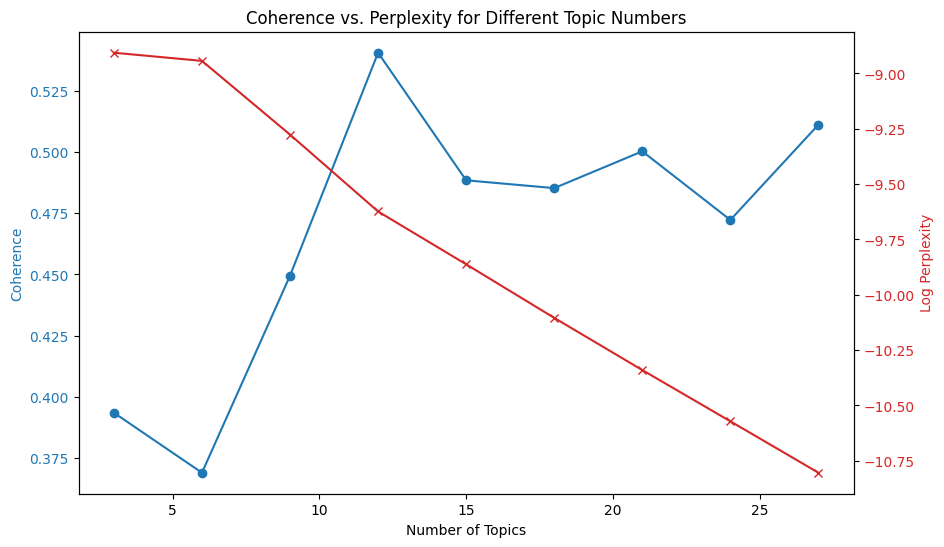

In [8]:
# Range of topic numbers
topic_nums = list(range(3, 30, 3))  # starts at 3, step 3
coherences = []
perplexities = []

for n in topic_nums:
    temp_model = models.LdaModel(corpus=corpus, num_topics=n, id2word=dictionary, passes=5)
    coh = CoherenceModel(model=temp_model, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
    perp = temp_model.log_perplexity(corpus)
    coherences.append(coh)
    perplexities.append(perp)
    #print(f"Topics: {n} | Coherence: {coh:.3f} | Log Perplexity: {perp:.3f}")

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Coherence', color=color)
ax1.plot(topic_nums, coherences, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Add a second y-axis for perplexity
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Log Perplexity', color=color)
ax2.plot(topic_nums, perplexities, marker='x', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Coherence vs. Perplexity for Different Topic Numbers')
plt.show()

### Interactive LDAVis

In [11]:
import pyLDAvis
import pyLDAvis.gensim_models

lda_model = models.LdaModel(corpus=corpus, num_topics=21, id2word=dictionary, passes=5)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.218729 -0.031534       1        1  18.081727
0     -0.207195 -0.042190       2        1  14.585689
2     -0.198756  0.106775       3        1  13.526484
18    -0.188258  0.100219       4        1   9.128100
8     -0.099673 -0.256968       5        1   5.423732
20    -0.113846 -0.195572       6        1   5.044004
11    -0.140506 -0.037907       7        1   4.929596
19    -0.075992  0.125012       8        1   4.817827
6     -0.098961 -0.007174       9        1   4.676305
9     -0.120023  0.065411      10        1   4.518747
1     -0.088641  0.112609      11        1   4.461847
14    -0.078503  0.053827      12        1   3.313718
4      0.006279  0.079577      13        1   2.866479
16     0.076909 -0.086095      14        1   1.330910
17     0.120467  0.039137      15        1   1.009325
5      0.116520 -0.077735      16        1   0.978786
7      0.208727  0.028802      17        1   0.781815
12     0.273027  0.006318      18        1   0.198641
13     0.276560  0.005098      19        1   0.134002
15     0.276595  0.006542      20        1   0.130191
10     0.273997  0.005849      21        1   0.062075, topic_info=             Term         Freq        Total Category  logprob  loglift
124        policy  7197.000000  7197.000000  Default  30.0000  30.0000
137      research  4787.000000  4787.000000  Default  29.0000  29.0000
565        public  4191.000000  4191.000000  Default  28.0000  28.0000
256     sentiment  3120.000000  3120.000000  Default  27.0000  27.0000
1662       health  2544.000000  2544.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
2692    hindering     0.346938     7.287525  Topic21  -7.2088   4.3398
20942      siting     0.365801     9.017558  Topic21  -7.1559   4.1797
27220  outpatient     0.263092     5.425328  Topic21  -7.4855   4.3583
18038  perceiving     0.216224     2.810983  Topic21  -7.6817   4.8196
15553     touches     0.188529     1.548249  Topic21  -7.8187   5.2790

[1448 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
673        1  0.023003         (ai)
673        2  0.017252         (ai)
673        3  0.218528         (ai)
673        4  0.057507         (ai)
673        5  0.005751         (ai)
...      ...       ...          ...
13763      6  0.442215        youth
13763      7  0.031587        youth
13763     14  0.315868        youth
10324      1  0.970337     “climate
34618     18  0.710008  “structural

[5191 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 19, 9, 21, 12, 20, 7, 10, 2, 15, 5, 17, 18, 6, 8, 13, 14, 16, 11])

In [12]:
topics_per_doc = [sorted(lda_model[doc], key=lambda x: -x[1])[0][0] for doc in corpus]
df['Dominant_Topic'] = topics_per_doc
df[['text', 'Dominant_Topic']].head()

,text,Dominant_Topic
0,Unveiling sustainable tourism themes with mach...,18
15,Investigating the higher education institution...,11
17,Integrating sustainability into cybersecurity:...,18
18,DrugGen enhances drug discovery with large lan...,19
20,Neural topic modeling reveals German televisio...,3


## BERTopic

In [13]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

docs = df['text'].tolist()

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

print(f"Shape of embeddings: {embeddings.shape}")

vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")

topic_model = BERTopic(
    vectorizer_model=vectorizer_model,
    language="english",
    min_topic_size=20  # Adjust as needed
)

topics, probs = topic_model.fit_transform(docs, embeddings)

topic_model.get_topic_info().head(10)

/Users/esalasgirones/Documents/work/courses/nlp_icpp/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/esalasgirones/Documents/work/courses/nlp_icpp/.venv/lib/python3.11/site-packages/spacy/cli/_util.py:23: DeprecationWarning: Importing 'parser.split_arg_string' is deprecated, it will only be available in 'shell_completion' in Click 9.0.
  from click.parser import split_arg_string
/Users/esalasgirones/Documents/work/courses/nlp_icpp/.venv/lib/python3.11/site-packages/weasel/util/config.py:8: DeprecationWarning: Importing 'parser.split_arg_string' is deprecated, it will only be available in 'shell_completion' in Click 9.0.
  from click.parser import split_arg_string
Batches: 100%|██████████| 158/158 [00:15<00:00,  9.88it/s]


Shape of embeddings: (5039, 384)


,Topic,Count,Name,Representation,Representative_Docs
0,-1,2,-1_crl_model_classification_severity,"[crl, model, classification, severity, data, c...",[BERT-based NLP techniques for classification ...
1,0,4817,0_policy_analysis_research_data,"[policy, analysis, research, data, study, publ...",[Changes in online public opinions associated ...
2,1,220,1_learning_reinforcement_language_reinforcemen...,"[learning, reinforcement, language, reinforcem...",[An efficient reinforcement learning method ba...


In [14]:
# Representative docs
topic_nr = 1
reps = topic_model.get_representative_docs(topic_nr)
for doc in reps[:3]:
    print("---")
    print(doc)

---
An efficient reinforcement learning method based on large language model; [大模型引导的高效强化学习方法]. Deep reinforcement learning, as a key technology supporting breakthrough works such as AlphaGo and ChatGPT, has become a research hotspot in frontier science. In practical applications, deep reinforcement learning, as an important intelligent decision-making technology, is widely used in a variety of planning and decision-making tasks, such as obstacle avoidance in visual scenes, optimal generation of virtual scenes, robotic arm control, digital design and manufacturing, and industrial design decision-making. However, deep reinforcement learning faces the challenge of low sample efficiency in practical applications, which greatly limits its application effectiveness. In order to improve the sample efficiency, this paper proposes an efficient exploration method based on large model guidance, which combines the large model with the mainstream exploration techniques. Specifically, we utilize th

In [15]:
# Visualize topics
topic_model.visualize_topics()

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
# Visualize barchart
topic_model.visualize_barchart()

In [ ]:
topic_model.visualize_document_datamap(docs, embeddings=embeddings)